#Create Environment 

In [1]:
!pip3 install box2d-py

     |████████████████████████████████| 450kB 5.5MB/s 


In [2]:

import numpy as np
import gym
import random
import time
env = gym.make("Taxi-v3")


#Define Hyperparameters

In [3]:
total_episodes = 30000        # Total episodes
learning_rate = 0.05         # Learning rate
max_steps = 99                # Max steps per episode
alpha = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1               # Exploration rate
decay_rate = 0.99           # Exponential decay rate for exploration prob

#Initialize Q-table

In [4]:
n_states = env.observation_space

In [5]:
n_states

Discrete(500)

In [6]:
n_actions= env.action_space.n
n_states = env.observation_space.n
q_t = np.zeros((n_states, n_actions))


#Retrace Algorithm

In [7]:
# List of rewards
rewards = []

for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    cs = 1
    Lambda = 1 

    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        t = random.uniform(0, 1)
        # We compute the probabilty mu 
        mu = 0 
        ## If this number > greater than epsilon --> exploitation 
        if t > epsilon:
            action = np.argmax(q_t[state,:])
            mu = (1-epsilon)
            
        
        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()
            mu = epsilon / (n_actions -1)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)
        a_star = np.argmax(q_t[new_state])
        probabilities = [epsilon / n_actions] * n_actions
        probabilities[a_star] += 1 - epsilon

        exp = 0
        cs  *=  Lambda * min(1, probabilities[a_star] / mu) 
        #print(cs)
        for i in range(n_actions):
        	exp += probabilities[i] * q_t[new_state, i]
        # Update Q(s,a) using equation 3 from the paper
        # qtable[new_state,:] : all the actions we can take from new state
        q_t[state, action] += cs * (reward + alpha * exp - q_t[state,action])
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon *= decay_rate
    rewards.append(total_rewards)

print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(q_t)

Score over time: 6.439566666666667
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -8.60812408  -8.01138909  -8.08611842  -7.93378324   5.20997639
  -13.41977514]
 [ -7.43772638  -7.09211629  -7.81813208  -7.60917174  10.9512375
  -14.68970694]
 ...
 [ -5.68909177  -3.80790198  -5.21531374  -4.2238642  -14.61752432
  -11.28153913]
 [-11.21237457 -10.70000636 -11.43329575 -10.86544688 -20.26594027
  -20.18703305]
 [ -1.14316701   7.60361688  -2.68322293  -1.08490914 -10.21459677
  -11.72952619]]


In [8]:
total_epochs, total_penalties = 0, 0
episodes = 100
frames = []

for ep in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_t[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1
        
        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'episode': ep, 
            'state': state,
            'action': action,
            'reward': reward
            }
        )
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.27
Average penalties per episode: 0.0


In [9]:
from IPython.display import clear_output
import time
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Episode: {frame['episode']}")
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(1)

In [10]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Episode: 99
Timestep: 1327
State: 410
Action: 5
Reward: 20


# The simulator 

In [3]:
# Possible values for algo: IS, Off-policy, TB, Retrace
def compute_cs(algo, mu, pi, Lambda): 
    if algo == "IS":
        return pi/mu
    if algo == "Off-policy":
        return Lambda
    if algo == "TB":
        return Lambda * pi
    if algo == "Retrace":
        return Lambda * min(1, pi/mu)

In [4]:
def simulator(env, algo= "Retrace", epsilon= 0.95, decay_rate= 0.99, total_episodes= 10, max_steps= 100, Lambda= 1, gamma= 1): 
    ''' function that simulate the training of an algorithm.
    inputs:
      env: a gym object containing the environment,
      algo: a string in this list  ["IS", "Off-policy", "TB", "Retrace"], represent the algorithme used to compute the Q-value.
      epsilon: a float between 0 and 1 for the epsilion-greedy part
      decay_rate: a flot between 0 and 1 it represent the speed of decay of the epsilion term in the epsilion-greedy part
      total_episodes: a positive intger represent the number of episodes to be simulated.
      max_steps: a positive intger represent the number of steps taken at each episode.
      Lambda: a float represnt the update in the Q-values.
      gamma: discount factor.
    outputs: 
      rewards: a list of rewards at each step.
      q_t: the Q values matrix.
    '''
    n_actions= env.action_space.n
    n_states = env.observation_space.n
    q_t = np.zeros((n_states, n_actions))

    # List of rewards
    rewards = []
    '''algorithm '''
    for episode in range(total_episodes):
        # Reset the environment
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        cs = 1 

        for step in range(max_steps):
            # 3. Choose an action a in the current world state (s)
            ## First we randomize a number
            t = random.uniform(0, 1)
            # We compute the probabilty mu 
            mu = 1 
            ## If this number > greater than epsilon --> exploitation 
            if t > epsilon:
                action = np.argmax(q_t[state,:])
                mu = 1 - epsilon
            # Else doing a random choice --> exploration
            else:
                action = env.action_space.sample()
                mu = epsilon / (n_actions - 1) 
            
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)
            a_star = np.argmax(q_t[new_state])
            probabilities = [epsilon / n_actions] * n_actions
            probabilities[a_star] += 1 - epsilon

            exp = 0
            cs  *=  compute_cs(algo= algo, mu= mu,
                            pi= probabilities[a_star], Lambda= Lambda) 

            for i in range(n_actions):
                exp += probabilities[i] * q_t[new_state, i]
            # Update Q(s,a) using equation 3 from the paper
            # qtable[new_state,:] : all the actions we can take from new state
            q_t[state, action] += (gamma**step) * cs * (reward + gamma * exp - q_t[state,action])
            
            total_rewards += reward
            
            # Our new state is state
            state = new_state
            # If done (if we're dead) : finish episode
            if done == True: 
                break
            
        # Reduce epsilon (because we need less and less exploration)
        epsilon *= decay_rate
        rewards.append(total_rewards)

    return rewards, q_t

## simulation

In [4]:
## Simulate all algo n times:
env = gym.make("Taxi-v3")
# simulation number 
n_sim = 10

# Hyperparameters 
total_episodes = 30000        # Total episodes
max_steps = 99                # Max steps per episode
alpha = 0.95                  # Discounting rate
Lambda = 1 # Lambda parameter
# Exploration parameters
epsilon = 0.4               # Exploration rate
decay_rate = 0.99         # Decay factor
# algos
algos = ["IS", "Off-policy", "TB", "Retrace"]


simulation_dict = {}
for algo in algos:
    simulation_dict[algo] = []
    for i in range(n_sim):
        start_time = time.time()
        iter_dict = {}
        print("computing iteration", i,'for the algorithme', algo)
        rewards, q_t = simulator(env= env, epsilon= epsilon,
                                decay_rate= decay_rate, total_episodes= total_episodes,
                                max_steps= max_steps, algo= algo,
                                Lambda= Lambda, gamma= alpha)
        iter_dict["rewards"] = rewards
        iter_dict["q_t"] = q_t
        end_time = time.time()
        iter_dict["time"] = end_time - start_time
        simulation_dict[algo].append(iter_dict)


for algo in algos:
    for i in range(n_sim):
        r = simulation_dict[algo][i]["rewards"]
        t = simulation_dict[algo][i]["time"]
        print ("algo: ", algo,
        "for iter ", i, "Score over time: ", sum(r)/total_episodes, " time ", t)

computing iteration 0 for the algorithme IS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


computing iteration 1 for the algorithme IS
computing iteration 2 for the algorithme IS
computing iteration 3 for the algorithme IS
computing iteration 4 for the algorithme IS
computing iteration 5 for the algorithme IS
computing iteration 6 for the algorithme IS
computing iteration 7 for the algorithme IS
computing iteration 8 for the algorithme IS
computing iteration 9 for the algorithme IS
computing iteration 0 for the algorithme Off-policy
computing iteration 1 for the algorithme Off-policy
computing iteration 2 for the algorithme Off-policy
computing iteration 3 for the algorithme Off-policy
computing iteration 4 for the algorithme Off-policy
computing iteration 5 for the algorithme Off-policy
computing iteration 6 for the algorithme Off-policy
computing iteration 7 for the algorithme Off-policy
computing iteration 8 for the algorithme Off-policy
computing iteration 9 for the algorithme Off-policy
computing iteration 0 for the algorithme TB
computing iteration 1 for the algorithme

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
dir = pd.DataFrame(columns= algos)
for algo in algos:
  for i in range(n_sim):
    if i == 0: 
      dir[algo] = simulation_dict[algo][i]["rewards"]
    if i != 0:
      dir[algo] += simulation_dict[algo][i]["rewards"]
dir = dir /n_sim


In [7]:
data = pd.DataFrame(columns= algos)
for i in range(0, int(total_episodes), 500):
  data.loc[i] = dir.loc[i]

In [14]:
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightblue'})

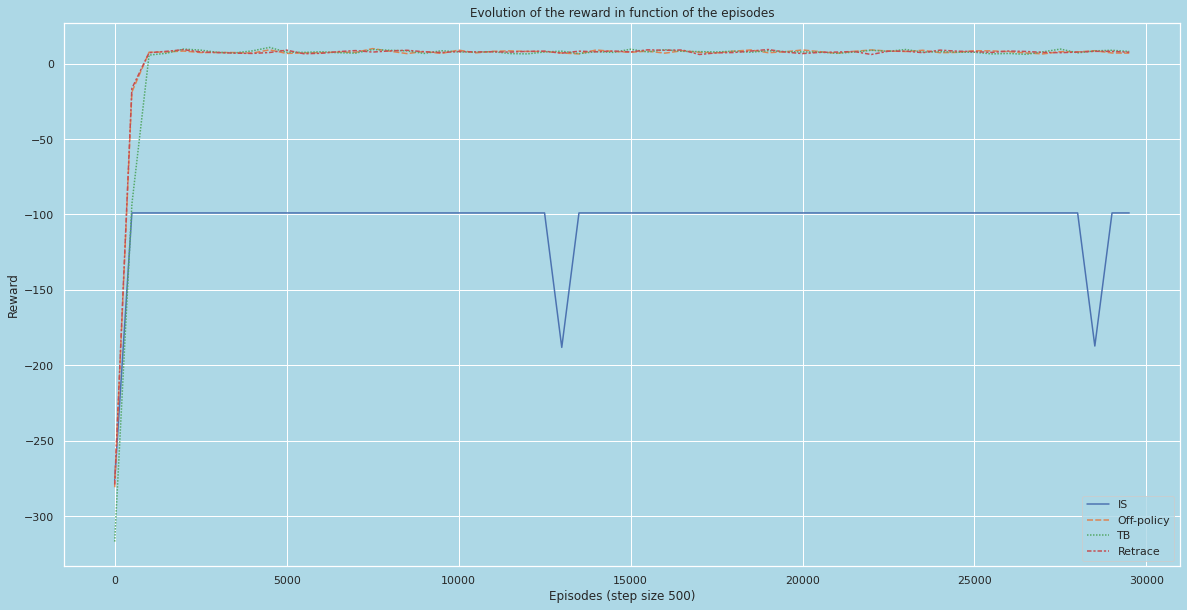

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data= data)
plt.xlabel("Episodes (step size 500)")
plt.ylabel("Reward")
plt.title("Evolution of the reward in function of the episodes")
plt.show()

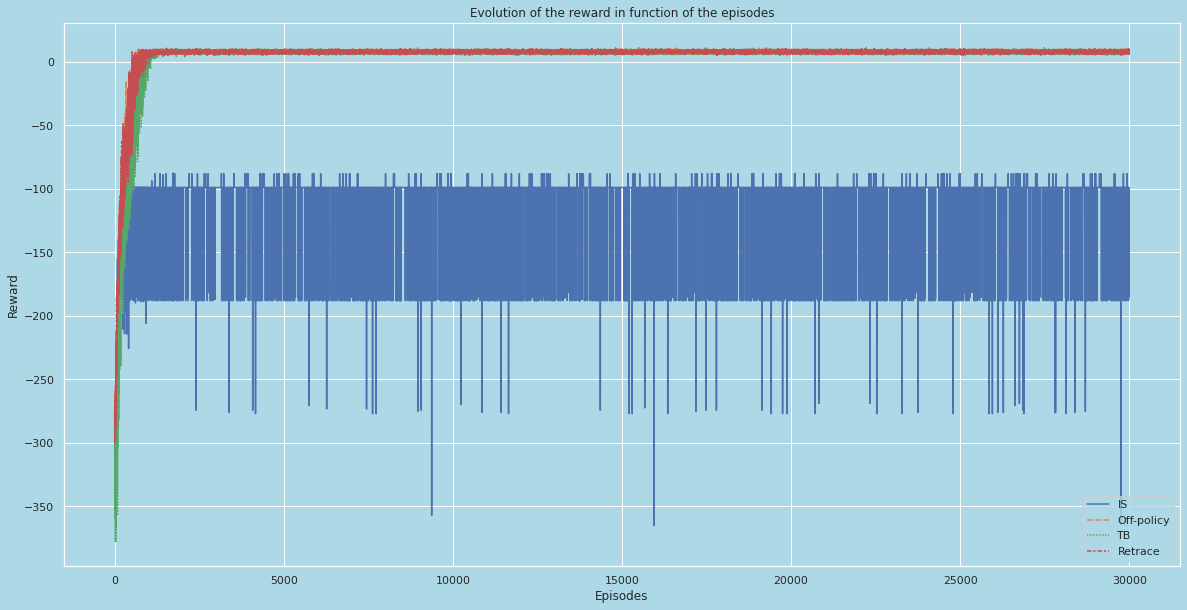

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightblue'})
sns.lineplot(data= dir)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Evolution of the reward in function of the episodes")
plt.show()

In [10]:
data2 = pd.DataFrame(columns= algos)
data2= dir.loc[1:total_episodes].reset_index() - dir.loc[0:total_episodes-1].reset_index() 

In [11]:
data3 = pd.DataFrame(columns= algos)
for i in range(0, int(total_episodes), 500):
  data3.loc[i] = np.abs(data2.loc[i])

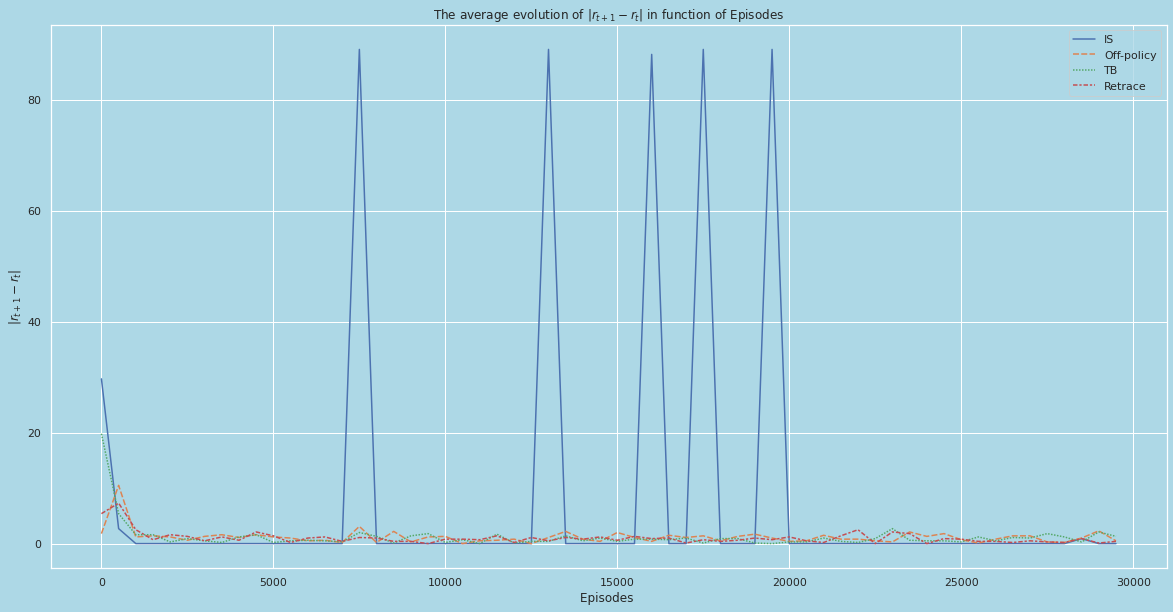

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data= data3)
plt.xlabel("Episodes ")
plt.ylabel("$|r_{t+1} - r_{t}|$")
plt.title("The average evolution of $|r_{t+1} - r_{t}|$ in function of Episodes")
plt.show()

In [11]:
dir = pd.DataFrame(columns= Lambda)
for l in Lambda:
  for i in range(n_sim):
    if i == 0: 
      dir[l] = simulation_dict[l][i]["rewards"]
    if i != 0:
      dir[l] += simulation_dict[l][i]["rewards"]
dir = dir /n_sim

In [12]:
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightblue'})

In [15]:
data = pd.DataFrame(columns= Lambda)
for i in range(0, int(total_episodes), 500):
  data.loc[i] = dir.loc[i]

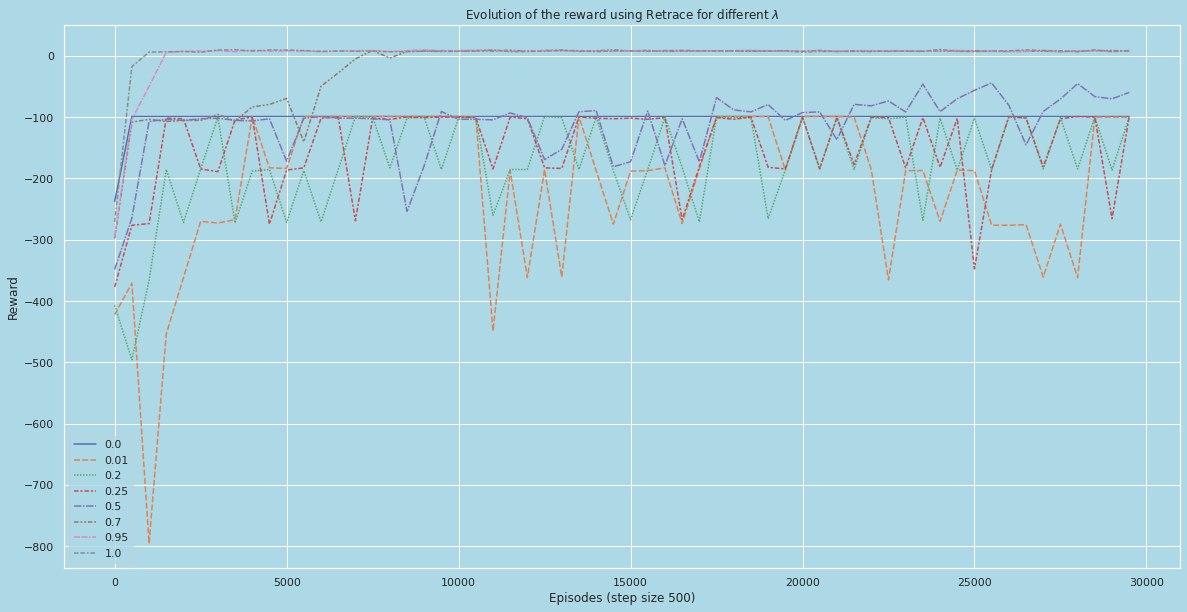

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data= data)
plt.xlabel("Episodes (step size 500)")
plt.ylabel("Reward")
plt.title("Evolution of the reward using Retrace for different $\lambda$")
plt.show()

In [5]:
## Simulate all algo n times:
env = gym.make("Taxi-v3")
# simulation number 
n_sim = 10

# Hyperparameters 
total_episodes = 30000        # Total episodes
max_steps = 99                # Max steps per episode
alpha = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 0.4               # Exploration rate
decay_rate = 0.99         # Decay factor
# algos
algos = ["IS", "Off-policy", "TB", "Retrace"]
Lambda = [0, 0.01, 0.2, 0.25, 0.5, 0.7, 0.95, 1] # Lambda parameter

simulation_dict = {}
algo = "Retrace"
for l in Lambda :
    simulation_dict[l] = []
    for i in range(n_sim):
        start_time = time.time()
        iter_dict = {}
        print("computing "+algo+", iteration", i,'with lambda', l)
        rewards, q_t = simulator(env= env, epsilon= epsilon,
                                decay_rate= decay_rate, total_episodes= total_episodes,
                                max_steps= max_steps, algo= algo,
                                Lambda= l, gamma= alpha)
        iter_dict["Lambda"] = l
        iter_dict["rewards"] = rewards
        iter_dict["q_t"] = q_t
        end_time = time.time()
        iter_dict["time"] = end_time - start_time
        simulation_dict[l].append(iter_dict)

computing Retrace, iteration 0 with lambda 0
computing Retrace, iteration 1 with lambda 0
computing Retrace, iteration 2 with lambda 0
computing Retrace, iteration 3 with lambda 0
computing Retrace, iteration 4 with lambda 0
computing Retrace, iteration 5 with lambda 0
computing Retrace, iteration 6 with lambda 0
computing Retrace, iteration 7 with lambda 0
computing Retrace, iteration 8 with lambda 0
computing Retrace, iteration 9 with lambda 0
computing Retrace, iteration 0 with lambda 0.01
computing Retrace, iteration 1 with lambda 0.01
computing Retrace, iteration 2 with lambda 0.01
computing Retrace, iteration 3 with lambda 0.01
computing Retrace, iteration 4 with lambda 0.01
computing Retrace, iteration 5 with lambda 0.01
computing Retrace, iteration 6 with lambda 0.01
computing Retrace, iteration 7 with lambda 0.01
computing Retrace, iteration 8 with lambda 0.01
computing Retrace, iteration 9 with lambda 0.01
computing Retrace, iteration 0 with lambda 0.2
computing Retrace, iter

In [74]:
for algo in algos:
    for i in range(len(Lambda)):
        r = simulation_dict[algo][i]["rewards"]
        t = simulation_dict[algo][i]["time"]
        print ("algo: ", algo,
        "for iter ", i, "Score over time: ", sum(r)/total_episodes, " time ", t)

algo:  IS for iter  0 Score over time:  -104.94116666666666  time  83.49553275108337
algo:  IS for iter  1 Score over time:  -111.09933333333333  time  82.20049619674683
algo:  IS for iter  2 Score over time:  -98.44376666666666  time  83.0127182006836
algo:  IS for iter  3 Score over time:  -105.74136666666666  time  83.25179886817932
algo:  IS for iter  4 Score over time:  -106.38376666666667  time  82.8010025024414
algo:  IS for iter  5 Score over time:  -107.72833333333334  time  82.70777535438538
algo:  IS for iter  6 Score over time:  -114.87746666666666  time  83.51476073265076
algo:  Off-policy for iter  0 Score over time:  -99.384  time  83.97126412391663
algo:  Off-policy for iter  1 Score over time:  -210.06323333333333  time  83.11424326896667
algo:  Off-policy for iter  2 Score over time:  -155.25716666666668  time  83.6459972858429
algo:  Off-policy for iter  3 Score over time:  -113.11936666666666  time  75.88594555854797
algo:  Off-policy for iter  4 Score over time:  -

In [10]:
dir = pd.DataFrame(columns=Lambda)
for l in Lambda :
  lr = []
  lt = []
  for i in range(n_sim):
    r = simulation_dict[l][i]["rewards"]
    r = sum(r)/total_episodes
    lr.append(r)
    lt.append(simulation_dict[l][i]["time"])
  dir[l] = np.mean(lt)
dir

,0.00,0.01,0.20,0.25,0.50,0.70,0.95,1.00
IS,74.77573,74.274843,74.08981,74.088087,66.516731,22.855109,12.144622,11.234317
Off-policy,74.77573,74.274843,74.08981,74.088087,66.516731,22.855109,12.144622,11.234317
TB,74.77573,74.274843,74.08981,74.088087,66.516731,22.855109,12.144622,11.234317
Retrace,74.77573,74.274843,74.08981,74.088087,66.516731,22.855109,12.144622,11.234317


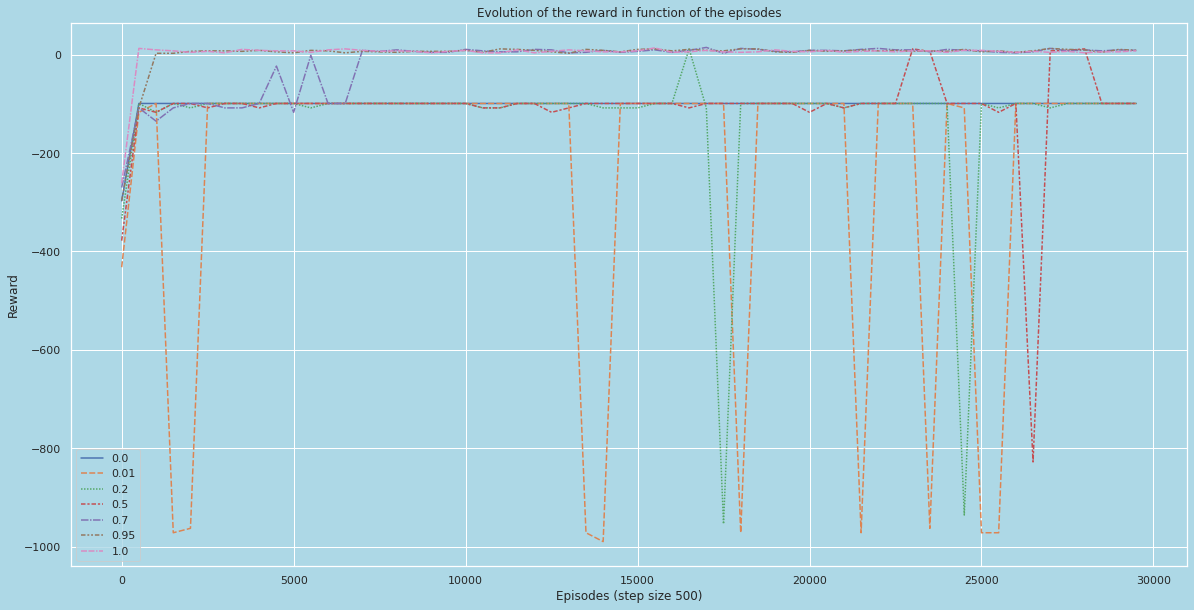

In [77]:
data_lambda = pd.DataFrame(columns=  [l for l in Lambda])
dor = dir.loc[1:total_episodes].reset_index() - dir.loc[0:total_episodes-1].reset_index() 
for i in range(0, total_episodes, 500):
  data_lambda.loc[i] = dir.loc[i]
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data= data_lambda.astype(float))
plt.xlabel("Episodes (step size 500)")
plt.ylabel("Reward")
plt.title("Evolution of the reward in function of the episodes")
plt.show()